In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from time import time

import scipy
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b
from sklearn.utils import check_random_state

import jax
import jax.numpy as jnp

from picard import amari_distance

from multiviewica_delay import (
    _apply_continuous_delays,
    multiviewica_delay,
)

# apply_delay functions

In [2]:
def apply_both_delays_1d(s, a=1, b=0, t0=0):
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a  
    # by writing (t-b)*a instead of t*a-b we allow the constant delay to be measurable in sample unit, 
    # i.e. constant_delay=5 means 5 samples, which corresponds to 5ms if the sampling rate is 1000Hz. 
    # It also means that we apply constant delay before cumulative delay, contrary to the paper on age-related delay.
    s_ab = jnp.interp(x=t_ab, xp=t, fp=s, left=0, right=0)
    return s_ab

def apply_both_delays_2d(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:  # if condition could cause a problem
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t, fp=S[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array(
        [apply_both_delays_2d(S_list[i], a=A[i], b=B[i], t0=t0)
         for i in range(len(S_list))])
    return Y_list

In [3]:
def apply_both_delays_1d_cyclic(s, a=1, b=0, t0=0):
    n = len(s)
    s_concat = jnp.concatenate([s[n-max_delay:], s, s[:max_delay]])
    t_concat = jnp.arange(len(s_concat)) - max_delay - t0
    t = jnp.arange(len(s)) - t0
    t_ab = (t - b) * a
    s_ab = jnp.interp(x=t_ab, xp=t_concat, fp=s_concat)
    return s_ab

def apply_both_delays_2d_cyclic(S, a=None, b=None, t0=0):
    p, n = S.shape
    if a is None:
        a = jnp.ones(p)
    if b is None:
        b = jnp.zeros(p)
        
    S_concat = jnp.concatenate([S[:, n-max_delay:], S, S[:, :max_delay]], axis=1)
    t_concat = jnp.arange(S_concat.shape[1]) - max_delay - t0

    t = jnp.arange(n) - t0
    T = jnp.array([t] * p)
    T_ab = ((T.T - b) * a).T
    S_ab = jnp.array(
        [jnp.interp(x=T_ab[i], xp=t_concat, fp=S_concat[i], left=0, right=0)
         for i in range(p)])
    return S_ab

def apply_both_delays_3d_cyclic(S_list, A=None, B=None, t0=0):
    Y_list = jnp.array([apply_both_delays_2d_cyclic(S_list[i], a=A[i], b=B[i], t0=t0) for i in range(len(S_list))])
    return Y_list

# find order function

In [4]:
def find_order(S1, S2):
    S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)
    S2 = S2 / np.linalg.norm(S2, axis=1, keepdims=True)
    M = np.abs(np.dot(S1, S2.T))
    try:
        _, order = scipy.optimize.linear_sum_assignment(-abs(M))
    except ValueError:
        order = np.arange(p)
    return order

# generate data

In [5]:
def soft_threshold(S, threshold=0.1):
    return np.sign(S) * np.maximum(0, np.abs(S) - threshold)

def generate_source_one_interval(interval_length, freqs):
    t = np.linspace(0, 6 * np.pi, interval_length)
    s = np.sum([np.sin(f * t) for f in freqs], axis=0) / len(freqs)
    return s

def generate_one_source(interval_length, freqs, power):
    s = np.array(
        [p * generate_source_one_interval(interval_length, freqs[i, :])
         for p, i in zip(power, range(len(power)))]).reshape(-1)
    return s

def generate_sources(p, n, nb_intervals=5, nb_freqs=20, rng=None):
    if rng is None:
        rng = check_random_state(0)
    interval_length = n // nb_intervals
    freqs = rng.randn(p, nb_intervals, nb_freqs)
    power = rng.exponential(size=(p, nb_intervals))
    S = np.array([generate_one_source(interval_length, freqs[i], power[i]) for i in range(p)])
    shifts = (rng.rand(p) * n).astype("int")
    S = np.array([np.roll(S[i], shift) for i, shift in enumerate(shifts)])
    return S

def gen_data(
    m,
    p,
    n,
    nb_intervals=5,
    nb_freqs=20,
    threshold=0.1,
    max_dilation=1.1,
    max_shift=20,
    t0=0,
    noise_data=0.1,
    rng=None,
):
    if rng is None:
        rng = check_random_state(0)
    S = generate_sources(p, n, nb_intervals, nb_freqs, rng)
    S = soft_threshold(S, threshold=threshold)
    A_list = rng.randn(m, p, p)
    noise_list = noise_data * rng.randn(m, p, n)
    S_list = np.array([S + N for N in noise_list])
    # add delays
    dilations = rng.uniform(low=1/max_dilation, high=max_dilation, size=(m, p))
    shifts = rng.uniform(low=-max_shift, high=max_shift, size=(m, p))
    # S_list = apply_both_delays_3d(S_list, A=dilations, B=shifts, t0=t0)
    S_list = apply_both_delays_3d_cyclic(S_list, A=dilations, B=shifts, t0=t0)
    X_list = np.array([np.dot(A, S) for A, S in zip(A_list, S_list)])
    return X_list, A_list, dilations, shifts, S_list, S

# params

In [6]:
# params
m = 5
p = 2
n = 600
nb_intervals = 5
nb_freqs = 10
threshold = 0.1
max_dilation = 1.
max_shift = 20
max_delay = (np.ceil((n + max_shift) * max_dilation) - n).astype("int")
t0 = 0
noise_data = 0.1
noise_model = 1

# loss function without dilations and with FFT

In [7]:
def _logcosh(X):
    Y = jnp.abs(X)
    return Y + jnp.log1p(jnp.exp(-2 * Y))

def loss_function_fft(W_delays, X_list, noise_model=1):
    m, p, _ = X_list.shape
    W_list, delays = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = _apply_continuous_delays(
        S_list=S_list,
        tau_list=-delays,
        shared_delays=False,
        multiple_subjects=True,
        use_jax=True,
    )
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [8]:
wrapper_loss_fft = jax.jit(loss_function_fft)

val_and_grad_fft = jax.jit(jax.value_and_grad(loss_function_fft))

def wrapper_grad_fft(W_delays, X_list, noise_model):
    _, grad = val_and_grad_fft(W_delays, X_list, noise_model)
    return np.array(grad)

# loss function with dilation and using interpolation

In [9]:
def loss_function_interp(W_list, dilations, shifts, X_list, noise_model=1, t0=0):
    _, p, _ = X_list.shape
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    # Y_list = apply_both_delays_3d(S_list, A=1/dilations, B=-shifts, t0=t0)
    Y_list = apply_both_delays_3d_cyclic(S_list, A=1/dilations, B=-shifts, t0=t0)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

def vector_to_parameters(W_delays, m, p):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    dilations = W_delays[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts = W_delays[m*p*(p+1):].reshape((m, p))
    return W_list, dilations, shifts

def wrapped_loss_interp(W_delays, *args):
    return loss_function_interp(*vector_to_parameters(W_delays, m, p), *args)

In [10]:
wrapper_loss_interp = jax.jit(wrapped_loss_interp)

val_and_grad_interp = jax.jit(jax.value_and_grad(wrapped_loss_interp))

def wrapper_grad_interp(W_delays, X_list, noise_model, t0):
    _, grad = val_and_grad_interp(W_delays, X_list, noise_model, t0)
    return np.array(grad)

# first call: jit

In [11]:
random_state = 0
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p))
shifts_init = jnp.zeros((m, p))

In [12]:
W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
W_delays_interp = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [13]:
jax.config.update('jax_enable_x64', True)

In [14]:
start = time()
wrapper_loss_fft(W_delays_fft, X_list, noise_model)
wrapper_grad_fft(W_delays_fft, X_list, noise_model)
print(f"time : {time() - start}")

time : 7.937244176864624


In [15]:
start = time()
wrapper_loss_interp(W_delays_interp, X_list, noise_model, t0)
wrapper_grad_interp(W_delays_interp, X_list, noise_model, t0)
print(f"time : {time() - start}")

time : 14.16148328781128


# run experiment

In [16]:
def run_experiment(random_state):
    rng = check_random_state(random_state)
    # generate data
    X_list, A_list, dilations, shifts, S_list, S = gen_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        threshold=threshold,
        max_dilation=max_dilation,
        max_shift=max_shift,
        t0=t0,
        noise_data=noise_data,
        rng=rng,
    )

    # initialization parameters
    W_list_true = np.array([np.linalg.inv(A) for A in A_list])
    W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
    dilations_init = jnp.ones((m, p))
    shifts_init = jnp.zeros((m, p))
    W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
    W_delays_interp = jnp.concatenate(
        [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])
    
    # LBFGS
    start_fft = time()
    res_fft = fmin_bfgs(
        wrapper_loss_fft, x0=W_delays_fft, args=(X_list, noise_model),
        fprime=wrapper_grad_fft, disp=False, gtol=1e-8)
    time_fft = time() - start_fft
    
    start_interp = time()
    res_interp = fmin_bfgs(
        wrapper_loss_interp, x0=W_delays_interp, args=(X_list, noise_model, t0),
        fprime=wrapper_grad_interp, disp=False, gtol=1e-8)
    time_interp = time() - start_interp
    
    # change results' shape
    W_fft = res_fft[:m*p**2].reshape((m, p, p))
    shifts_fft = res_fft[m*p**2:].reshape((m, p))
    W_interp = res_interp[:m*p**2].reshape((m, p, p))
    dilations_interp = res_interp[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts_interp = res_interp[m*p*(p+1):].reshape((m, p))
    
    # MVICAD
    start_mvicad = time()
    _, W_mvicad, S_mvicad, _, shifts_mvicad, _ = multiviewica_delay(
        X_list,
        init=np.array(W_list_init),
        shared_delays=False,
        max_delay=max_shift,
        random_state=random_state,
        continuous_delays=False,
    )
    time_mvicad = time() - start_mvicad
    shifts_mvicad[shifts_mvicad > n // 2] -= n
    
    # Amari distance
    amari_fft = np.mean([amari_distance(W, A) for W, A in zip(W_fft, A_list)])
    amari_interp = np.mean([amari_distance(W, A) for W, A in zip(W_interp, A_list)])
    amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
    W_random = rng.randn(m, p, p)
    amari_random = np.mean([amari_distance(W, A) for W, A in zip(W_random, A_list)])

    # compute average sources
    S_fft = np.mean([np.dot(W, X) for W, X in zip(W_fft, X_list)], axis=0)
    S_interp = np.mean([np.dot(W, X) for W, X in zip(W_interp, X_list)], axis=0)
    
    # order
    order_fft = find_order(S, S_fft)
    shifts_fft = shifts_fft[:, order_fft]
    order_interp = find_order(S, S_interp)
    dilations_interp = dilations_interp[:, order_interp]
    shifts_interp = shifts_interp[:, order_interp]
    order_mvicad = find_order(S, S_mvicad)
    shifts_mvicad = shifts_mvicad[:, order_mvicad]
    
    # delay error
    shifts_error_fft = np.mean(np.abs(shifts_fft - shifts))
    shifts_error_interp = np.mean(np.abs(shifts_interp - shifts))
    shifts_error_mvicad = np.mean(np.abs(shifts_mvicad - shifts))
    nb_seeds_random = 10
    shifts_error_random = 0
    for _ in range(nb_seeds_random):
        shifts_random = rng.randint(low=-max_shift, high=max_shift, size=np.shape(shifts))
        shifts_error_random += np.mean(np.abs(shifts_random - shifts))
    shifts_error_random /= nb_seeds_random
    
    # result
    dict_res = {"amari_fft": [amari_fft],
                "amari_interp": [amari_interp],
                "amari_mvicad": [amari_mvicad],
                "amari_random": [amari_random],
                "time_fft": [time_fft],
                "time_interp": [time_interp],
                "time_mvicad": [time_mvicad],
                "shifts_error_fft": [shifts_error_fft],
                "shifts_error_interp": [shifts_error_interp],
                "shifts_error_mvicad": [shifts_error_mvicad],
                "shifts_error_random": [shifts_error_random]}
    return dict_res

# multiple seeds

In [17]:
# ~2sec per seed
nb_seeds = 10
df_res = pd.DataFrame()
for random_state in range(nb_seeds):
    dict_expe = run_experiment(random_state)
    df_expe = pd.DataFrame(dict_expe)
    df_res = pd.concat([df_res, df_expe], ignore_index=True)

/tmp/ipykernel_5577/1469475027.py:2: RuntimeWarning: invalid value encountered in true_divide
  S1 = S1 / np.linalg.norm(S1, axis=1, keepdims=True)


# plot

In [18]:
# compute average random Amari distance and shifts error
mean_amari_random = np.mean(df_res['amari_random'])
mean_shifts_error_random = np.mean(df_res['shifts_error_random'])

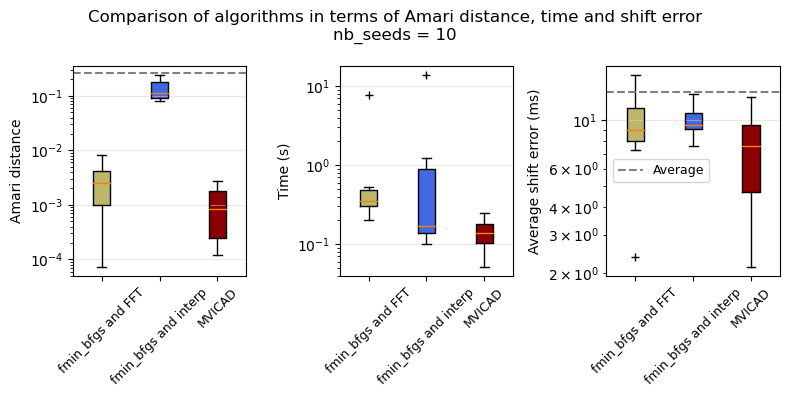

In [19]:
# plot
def one_subplot(data, ylabel, ax, logscale=False, average=None):
    bp = ax.boxplot(data)
    ax.set(ylabel=ylabel)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.setp(bp['fliers'], color='red', marker='+')
    box_colors = ['darkkhaki', 'royalblue', 'darkred']
    nb_algos = len(data)
    for i in range(nb_algos):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i]))
    ax.set_xticklabels(['fmin_bfgs and FFT', 'fmin_bfgs and interp', 'MVICAD'], rotation=45, fontsize=9)
    if logscale is True:
        ax.set_yscale('log')
    if average is not None:
        ax.axhline(average, c='grey', linestyle='--')

fig, axs = plt.subplots(1, 3, figsize=(8, 4))

one_subplot(
    [df_res['amari_fft'], df_res['amari_interp'], df_res['amari_mvicad']], 
    'Amari distance', 
    axs[0], 
    logscale=True,
    average=mean_amari_random)
one_subplot(
    [df_res['time_fft'], df_res['time_interp'], df_res['time_mvicad']],
    'Time (s)',
    axs[1],
    logscale=True)
one_subplot(
    [df_res['shifts_error_fft'], df_res['shifts_error_interp'], df_res['shifts_error_mvicad']],
    'Average shift error (ms)',
    axs[2],
    logscale=True,
    average=mean_shifts_error_random)

from matplotlib.lines import Line2D
plt.legend([Line2D([0], [0], linestyle='--', color='grey', lw=1.5)], ['Average'], fontsize=9)

plt.suptitle(f"Comparison of algorithms in terms of Amari distance, time and shift error\nnb_seeds = {nb_seeds}")
plt.tight_layout()

In [20]:
df_res

,amari_fft,amari_interp,amari_mvicad,amari_random,time_fft,time_interp,time_mvicad,shifts_error_fft,shifts_error_interp,shifts_error_mvicad,shifts_error_random
0,0.004036,0.080123,0.002686,0.279548,7.751668,13.740888,0.089263,9.105520,9.352124,11.280013,13.046217
1,0.001537,0.239198,0.001839,0.239524,0.389017,0.160565,0.109672,11.848481,7.595842,9.343907,12.395507
2,0.004287,0.195210,0.000325,0.219689,0.515267,0.181369,0.099885,11.611684,13.140355,12.788901,14.969216
3,0.001397,0.223163,0.000188,0.365127,0.325584,0.100213,0.157922,8.396274,10.822830,9.482442,15.258481
4,0.000073,0.095253,0.000120,0.239239,0.293509,0.125835,0.226403,2.363733,8.707632,2.182328,13.174838
5,0.004153,0.114805,0.000225,0.316662,0.199506,0.132257,0.247017,10.513572,9.123729,2.137794,13.383000
6,0.003504,0.090274,0.002418,0.323127,0.522911,1.137200,0.051708,7.950722,9.060838,5.857076,11.390785
7,0.000860,0.146742,0.001236,0.225936,0.354138,0.165028,0.130489,8.866337,10.475573,4.405617,13.774071
8,0.008149,0.108978,0.001725,0.151453,0.339921,1.233855,0.188466,16.032845,12.568953,9.457885,13.343420
9,0.000493,0.079309,0.000461,0.296322,0.280413,0.175522,0.143065,7.269923,9.641098,5.582995,13.305767


# Amari distance across iterations

In [53]:
def amari_callable(W_delays, A_list):
    W_list = W_delays[:m*p**2].reshape((m, p, p))
    amari = np.mean([amari_distance(W, A) for W, A in zip(W_list, A_list)])
    return amari

class Amari_callback():
    def __init__(self, A_list):
        self.memory = []
        self.A_list = A_list
    
    def __call__(self, W_delays):
        self.memory.append(amari_callable(W_delays, self.A_list))
    
callback = Amari_callback(A_list)

In [22]:
random_state = 58374
rng = check_random_state(random_state)
# generate data
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p))
shifts_init = jnp.zeros((m, p))
W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
W_delays_interp = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

# LBFGS
# res_fft = fmin_bfgs(
#     wrapper_loss_fft, x0=W_delays_fft, args=(X_list, noise_model),
#     fprime=wrapper_grad_fft, callback=amari_callable, gtol=1e-8)

res_interp = fmin_bfgs(
    wrapper_loss_interp, x0=W_delays_interp, args=(X_list, noise_model, t0),
    fprime=wrapper_grad_interp, callback=amari_callable, gtol=1e-8)

0.047317734905075806
0.04846631784521595
0.06222785178593525
0.08970227808781697
0.12518118538606482
0.15459470898562047
0.16418030257517882
0.15631954616352534
0.08617107632944082
0.08622490862661757
0.08581766213077521
0.08498308056459977
0.0760712327354113
0.07903396824243478
0.07641597618011323
0.07264522829322255
0.07949335545884603
0.09353639928265024
0.10939446959575916
0.10678068707921864
0.10908617555612951
0.10609650633374841
0.10517134980815017
0.10061235755189406
0.09823407169526181
0.09817144488625594
         Current function value: -16.131031
         Iterations: 26
         Function evaluations: 160
         Gradient evaluations: 156


In [23]:
W_interp = res_interp[:m*p**2].reshape((m, p, p))
dilations_interp = res_interp[m*p**2: m*p*(p+1)].reshape((m, p))
shifts_interp = res_interp[m*p*(p+1):].reshape((m, p))

print(f"Dilations : {dilations_interp}")

Dilations : [[ 0.77022899  3.26643694]
 [-5.29994914 11.27477972]
 [-0.42301134  0.77234823]
 [ 3.79837749 -7.21105382]
 [ 4.14096389 -1.23350633]]


Dilations are far too high when using fmin_bfgs (not bounded)!

# compare both apply_delay() functions

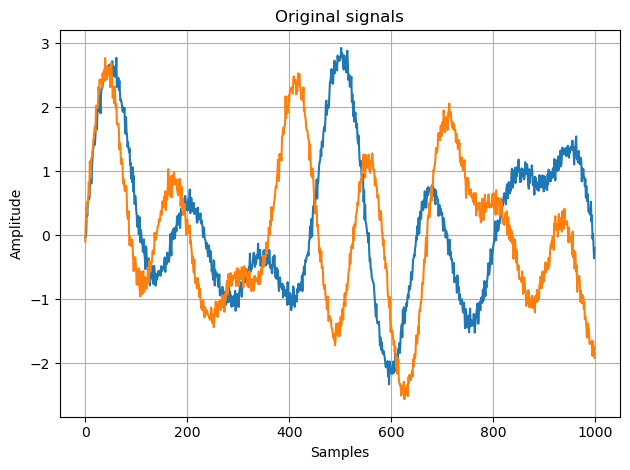

In [24]:
random_state = 23
rng = check_random_state(random_state)
nb_subjects = 3
nb_sources = 2
nb_freqs = 3
sr = 1000
t = np.linspace(0, 2 * np.pi, sr, endpoint=False)
T = np.array([t] * nb_sources)
freqs = rng.uniform(low=1, high=8, size=(nb_freqs, nb_sources))
S = np.zeros((nb_sources, sr))
for freq in freqs:
    S += np.sin(freq * T.T).T
S += 0.1 * rng.randn(nb_sources, sr)

S_list = np.array([S] * nb_subjects)

plt.plot(S.T)
plt.grid()
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Original signals")
plt.tight_layout()
plt.show()

In [25]:
shifts = rng.uniform(low=-100, high=100, size=(nb_subjects, nb_sources))
shifts

array([[ 82.23668499,  21.57814051],
       [ 31.6559679 , -19.31999477],
       [ 49.4936745 , -70.19380915]])

In [26]:
Y_list_1 = _apply_continuous_delays(
    S_list=S_list,
    tau_list=shifts,
    shared_delays=False,
    multiple_subjects=True,
    use_jax=True,
)

In [27]:
Y_list_2 = apply_both_delays_3d_cyclic(S_list, A=np.ones((nb_subjects, nb_sources)), B=shifts, t0=0)

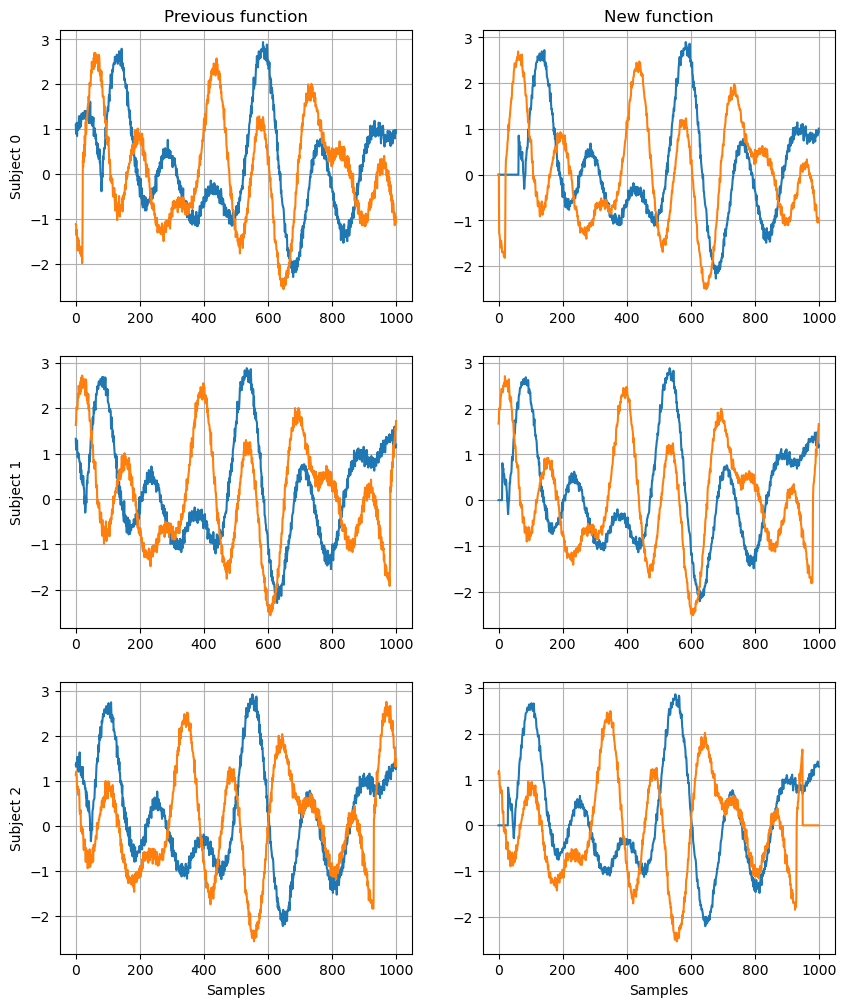

In [28]:
plt.subplots(nb_subjects, 2, figsize=(10, nb_subjects*4))

for i in range(nb_subjects):
    plt.subplot(nb_subjects, 2, 2 * i + 1)
    plt.plot(Y_list_1[i].T)
    plt.grid()
    plt.ylabel(f"Subject {i}")
    if i == 0:
        plt.title("Previous function")
    if i == nb_subjects - 1:
        plt.xlabel("Samples")
    
    plt.subplot(nb_subjects, 2, 2 * i + 2)
    plt.plot(Y_list_2[i].T)
    plt.grid()
    if i == 0:
        plt.title("New function")
    if i == nb_subjects - 1:
        plt.xlabel("Samples")

It appears that both apply_delay() functions give the same result. Note that the previous function produces signals with a little bit more noise (probably due to the loss of information using FFT and iFFT). 

# loss using interpolation but without dilation: does the Amari distance still increase?

In [29]:
def apply_shift_1d(s, b=0):
    t = jnp.arange(len(s))
    t_b = t - b
    s_b = jnp.interp(x=t_b, xp=t, fp=s, left=0, right=0)
    return s_b

def apply_shifts_2d(S, b=None):
    p, n = S.shape
    if b is None:
        b = jnp.zeros(p)
    t = jnp.arange(n)
    T = jnp.array([t] * p)
    T_b = (T.T - b).T
    S_b = jnp.array(
        [jnp.interp(x=T_b[i], xp=t, fp=S[i], left=0, right=0)
         for i in range(p)])
    return S_b

def apply_shifts_3d(S_list, B=None):
    Y_list = jnp.array(
        [apply_shifts_2d(S_list[i], b=B[i])
         for i in range(len(S_list))])
    return Y_list

In [30]:
def loss_function_interp_shift(W_delays, X_list, noise_model=1):
    m, p, _ = X_list.shape
    W_list, shifts = W_delays[:m*p**2].reshape((m, p, p)), W_delays[m*p**2:].reshape((m, p))
    S_list = jnp.array([jnp.dot(W, X) for W, X in zip(W_list, X_list)])
    Y_list = apply_shifts_3d(S_list, B=-shifts)
    Y_avg = jnp.mean(Y_list, axis=0)
    loss = jnp.mean(_logcosh(Y_avg)) * p
    for W, Y in zip(W_list, Y_list):
        loss -= jnp.linalg.slogdet(W)[1]
        loss += 1 / (2 * noise_model) * jnp.mean((Y - Y_avg) ** 2) * p
    return loss

In [31]:
wrapper_loss_interp_shift = jax.jit(loss_function_interp_shift)

val_and_grad_interp_shift = jax.jit(jax.value_and_grad(loss_function_interp_shift))

def wrapper_grad_interp_shift(W_delays, X_list, noise_model):
    _, grad = val_and_grad_interp_shift(W_delays, X_list, noise_model)
    return np.array(grad)

In [32]:
random_state = 583
rng = check_random_state(random_state)
# generate data
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

# initialization parameters
W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
shifts_init = jnp.zeros((m, p))
W_delays_interp_shift = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])

In [33]:
start = time()
wrapper_loss_interp_shift(W_delays_interp_shift, X_list, noise_model)
wrapper_grad_interp_shift(W_delays_interp_shift, X_list, noise_model)
print(f"time : {time() - start}")

time : 11.19568133354187


In [34]:
# LBFGS
res_interp_shift = fmin_bfgs(
    wrapper_loss_interp_shift, x0=W_delays_interp_shift, args=(X_list, noise_model),
    fprime=wrapper_grad_interp_shift, callback=amari_callable, gtol=1e-8)

0.05362513246173698
0.031930912884166884
0.052613699468135065
0.02154456969690822
0.03310151059397082
0.01334207714002431
0.016490403672756913
0.049001771517701034
0.059299264173941824
0.042670680739667136
0.017113828276868737
0.020817828935230008
0.01894927464126338
0.017876570576450146
0.02188521173770729
0.024441499687615397
0.033786306498359966
0.03563658026728215
0.03823154380337853
0.040799119050437385
0.04432813364311614
0.04754620832978036
0.05022225032997633
0.051284231548815215
0.05380409153167166
0.05629012774378607
0.057422097307087236
0.056116137207613326
0.055562948761992394
0.05515055916007703
0.05481573351052108
0.054371066215269305
0.05414286848901293
0.05393987302533506
0.0540159373560837
0.05401465013510963
0.05404810871250073
0.054019084907779236
0.05387308482928125
0.053864222528898296
0.053756307886148956
0.053801393761775326
0.05384859587470483
0.05394143712028586
0.05402753415262829
0.05409727612301134
0.05412588606587089
0.05411490951198483
0.054069408302293495

Idea: the problem with the new apply_delay() function lies in the fact that dilation parameters aren't bounded when using fmin_bfgs. Thus, they often are very high. This will maybe change with fmin_l_bfgs_b. I should try now to implement fmin_l_bfgs_b with shifts only and later add dilations. 

# fmin_l_bfgs_b with previous apply_delay() function

In [35]:
bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
bounds_shifts = [(-max_shift, max_shift)] * (m * p)
bounds_W_shifts = jnp.array(bounds_W + bounds_shifts)

In [36]:
def wrapper_loss_and_grad_fft(W_delays, X_list, noise_model):
    loss, grad = val_and_grad_fft(W_delays, X_list, noise_model)
    return loss, np.array(grad)

In [37]:
random_state = 6239287
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
shifts_init = jnp.zeros((m, p))
W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])

In [38]:
res_fft_lbfgsb = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_fft,
    x0=W_delays_fft,
    args=(X_list, noise_model),
    bounds=bounds_W_shifts,
    callback=amari_callable,
    disp=False,
    pgtol=1e-6,
)

0.04644379568472247
0.040640348877732255
0.03599132913195389
0.0320427204700793
0.029398692688271333
0.016725266422197294
0.019611643796511015
0.1217459878255563
0.16400601147829258
0.12216658663564191
0.06617158194947037
0.08348268985258227
0.08351882796337733
0.059324576712682896
0.05786384512423374
0.058833218042828
0.06329612751900168
0.06626135438050475
0.06474124982572607
0.06294465835049765
0.060016332429350304
0.05320411415138245
0.03703687953923281
0.040085767186261334
0.03955445527024454
0.03942667530013163
0.038460606018690266
0.038775362655952925
0.03906331493861974
0.04021591452094888
0.042336622175398964
0.041445040059828374
0.041570785620645555
0.041780930587436885
0.041850587032623066
0.0436397370716741
0.04551127244213295
0.047672065688912094
0.05407083729931965
0.06135476942817551
0.0657061749781131
0.053956971895967806
0.05351905371797809
0.05053601707549932
0.044875291623480126
0.034237596425132924
0.017878320694318717
0.016739097463555997
0.016537926548752323
0.017

fmin_l_bfgs_b with the previous apply_delay() function works fine. Its only drawback is that I feel that the parameter pgtol has no impact when it is less than 1e-5 (even when we specify jax.config.update('jax_enable_x64', True)).

# fmin_l_bfgs_b with new apply_delay() function

In [39]:
bounds_dilations = [(1/max_dilation, max_dilation)] * (m * p)
bounds_W_dilations_shifts = jnp.array(bounds_W + bounds_dilations + bounds_shifts)

In [40]:
def wrapper_loss_and_grad_interp(W_delays, X_list, noise_model, t0):
    loss, grad = val_and_grad_interp(W_delays, X_list, noise_model, t0)
    return loss, np.array(grad)

In [41]:
random_state = 623
rng = check_random_state(random_state)
X_list, A_list, dilations, shifts, S_list, S = gen_data(
    m=m,
    p=p,
    n=n,
    nb_intervals=nb_intervals,
    nb_freqs=nb_freqs,
    threshold=threshold,
    max_dilation=max_dilation,
    max_shift=max_shift,
    t0=t0,
    noise_data=noise_data,
    rng=rng,
)

W_list_true = np.array([np.linalg.inv(A) for A in A_list])
W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
dilations_init = jnp.ones((m, p))
shifts_init = jnp.zeros((m, p))
W_delays_interp = jnp.concatenate(
    [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])

In [55]:
res_interp_lbfgsb = fmin_l_bfgs_b(
    func=wrapper_loss_and_grad_interp,
    x0=W_delays_interp,
    args=(X_list, noise_model, t0),
    bounds=bounds_W_dilations_shifts,
    callback=callback,
    disp=True,
    factr=0,
    pgtol=1e-6,
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           40     M =           10

At X0        10 variables are exactly at the bounds

At iterate    0    f= -3.30528D+00    |proj g|=  3.08333D+00

At iterate    1    f= -6.07530D+00    |proj g|=  9.41364D-01

At iterate    2    f= -7.22335D+00    |proj g|=  6.20875D-01

At iterate    3    f= -9.22614D+00    |proj g|=  3.67930D-01

At iterate    4    f= -1.01061D+01    |proj g|=  2.68830D-01

At iterate    5    f= -1.03562D+01    |proj g|=  2.10357D-01

At iterate    6    f= -1.03780D+01    |proj g|=  2.01157D-01

At iterate    7    f= -1.03833D+01    |proj g|=  2.06307D-01

At iterate    8    f= -1.04021D+01    |proj g|=  2.17890D-01

At iterate    9    f= -1.04417D+01    |proj g|=  2.31557D-01

At iterate   10    f= -1.05341D+01    |proj g|=  2.46359D-01

At iterate   11    f= -1.06916D+01    |proj g|=  2.47394D-01

At iterate   12    f= -1.08540D+01    |proj g|=  2.51353D-01

At iterate   13    f= -1.0

In [51]:
callback.memory

[0.05659230234969455,
 0.08219036025018042,
 0.16570741466140718,
 0.2251987952265046,
 0.2559723716873178,
 0.26599237781299906,
 0.2685335820360907,
 0.27453272247097416,
 0.28241139402263693,
 0.2937508076213716,
 0.3012331038227451,
 0.302860038143373,
 0.2861411767904939,
 0.27629364357094405,
 0.27509445428131274,
 0.2755617774269098,
 0.27679800405975336,
 0.2781577972708845,
 0.2780681495467871,
 0.26927235297762525,
 0.2550564689135747,
 0.24188126301992682,
 0.22802405786168878,
 0.21860883620667598,
 0.2175877128803553,
 0.21670923111929635,
 0.2167444949979341,
 0.2167972918998149,
 0.21667752133983567,
 0.21607134823831622,
 0.2146609497594941,
 0.21255651012905413,
 0.21075440439993018,
 0.2101269384318271,
 0.2100113431844401,
 0.20998754510726364,
 0.21003622451787476,
 0.21013416055668968,
 0.21023035279145522,
 0.21006721459777022,
 0.20863979541213967,
 0.20346838760370156,
 0.1934643801561297,
 0.18239442945339662,
 0.17636458900959245,
 0.17090086732740636,
 0.1675

Works well but performs a lot of iterations, no matter pgtol. 

# benchmark with or without dilations

In [43]:
def run_experiment_all_functions(random_state):
    rng = check_random_state(random_state)
    # generate data
    X_list, A_list, dilations, shifts, S_list, S = gen_data(
        m=m,
        p=p,
        n=n,
        nb_intervals=nb_intervals,
        nb_freqs=nb_freqs,
        threshold=threshold,
        max_dilation=max_dilation,
        max_shift=max_shift,
        t0=t0,
        noise_data=noise_data,
        rng=rng,
    )

    # initialization parameters
    W_list_true = np.array([np.linalg.inv(A) for A in A_list])
    W_list_init = W_list_true + 0.2 * rng.randn(m, p, p)
    dilations_init = jnp.ones((m, p))
    shifts_init = jnp.zeros((m, p))
    W_delays_fft = jnp.concatenate([jnp.ravel(W_list_init), jnp.ravel(shifts_init)])
    W_delays_interp = jnp.concatenate(
        [jnp.ravel(W_list_init), jnp.ravel(dilations_init), jnp.ravel(shifts_init)])
    
    # fmin_lbfgs
    start_fft = time()
    res_fft = fmin_bfgs(
        wrapper_loss_fft, x0=W_delays_fft, args=(X_list, noise_model),
        fprime=wrapper_grad_fft, disp=False, gtol=1e-8)
    time_fft = time() - start_fft
    
    start_interp = time()
    res_interp = fmin_bfgs(
        wrapper_loss_interp, x0=W_delays_interp, args=(X_list, noise_model, t0),
        fprime=wrapper_grad_interp, disp=False, gtol=1e-8)
    time_interp = time() - start_interp
    
    # change fmin_lbfgs results' shape
    W_fft = res_fft[:m*p**2].reshape((m, p, p))
    shifts_fft = res_fft[m*p**2:].reshape((m, p))
    W_interp = res_interp[:m*p**2].reshape((m, p, p))
    dilations_interp = res_interp[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts_interp = res_interp[m*p*(p+1):].reshape((m, p))
    
    # bounds
    bounds_W = [(-jnp.inf, jnp.inf)] * (m * p ** 2)
    bounds_shifts = [(-max_shift, max_shift)] * (m * p)
    bounds_W_shifts = jnp.array(bounds_W + bounds_shifts)
    bounds_dilations = [(1/max_dilation, max_dilation)] * (m * p)
    bounds_W_dilations_shifts = jnp.array(bounds_W + bounds_dilations + bounds_shifts)

    # fmin_l_bfgs_b
    start_fft_lbfgsb = time()
    res_fft_lbfgsb = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_fft,
        x0=W_delays_fft,
        args=(X_list, noise_model),
        bounds=bounds_W_shifts,
        pgtol=1e-6,
    )
    time_fft_lbfgsb = time() - start_fft_lbfgsb
    
    start_interp_lbfgsb = time()
    res_interp_lbfgsb = fmin_l_bfgs_b(
        func=wrapper_loss_and_grad_interp,
        x0=W_delays_interp,
        args=(X_list, noise_model, t0),
        bounds=bounds_W_dilations_shifts,
        pgtol=1e-6,
    )
    time_interp_lbfgsb = time() - start_interp_lbfgsb
    
    # change fmin_l_bfgs_b results' shape
    W_delays_fft_lbfgsb = res_fft_lbfgsb[0]
    W_fft_lbfgsb = W_delays_fft_lbfgsb[:m*p**2].reshape((m, p, p))
    shifts_fft_lbfgsb = W_delays_fft_lbfgsb[m*p**2:].reshape((m, p))
    
    W_delays_interp_lbfgsb = res_interp_lbfgsb[0]
    W_interp_lbfgsb = W_delays_interp_lbfgsb[:m*p**2].reshape((m, p, p))
    dilations_interp_lbfgsb = W_delays_interp_lbfgsb[m*p**2: m*p*(p+1)].reshape((m, p))
    shifts_interp_lbfgsb = W_delays_interp_lbfgsb[m*p*(p+1):].reshape((m, p))
    
    # MVICAD
    start_mvicad = time()
    _, W_mvicad, S_mvicad, _, shifts_mvicad, _ = multiviewica_delay(
        X_list,
        init=np.array(W_list_init),
        shared_delays=False,
        max_delay=max_shift,
        random_state=random_state,
        continuous_delays=False,
    )
    time_mvicad = time() - start_mvicad
    shifts_mvicad[shifts_mvicad > n // 2] -= n
    
    # Amari distance
    amari_fft = np.mean([amari_distance(W, A) for W, A in zip(W_fft, A_list)])
    amari_interp = np.mean([amari_distance(W, A) for W, A in zip(W_interp, A_list)])
    amari_fft_lbfgsb = np.mean([amari_distance(W, A) for W, A in zip(W_fft_lbfgsb, A_list)])
    amari_interp_lbfgsb = np.mean([amari_distance(W, A) for W, A in zip(W_interp_lbfgsb, A_list)])
    amari_mvicad = np.mean([amari_distance(W, A) for W, A in zip(W_mvicad, A_list)])
    W_random = rng.randn(m, p, p)
    amari_random = np.mean([amari_distance(W, A) for W, A in zip(W_random, A_list)])

    # compute average sources
    S_fft = np.mean([np.dot(W, X) for W, X in zip(W_fft, X_list)], axis=0)
    S_interp = np.mean([np.dot(W, X) for W, X in zip(W_interp, X_list)], axis=0)
    S_fft_lbfgsb = np.mean([np.dot(W, X) for W, X in zip(W_fft_lbfgsb, X_list)], axis=0)
    S_interp_lbfgsb = np.mean([np.dot(W, X) for W, X in zip(W_interp_lbfgsb, X_list)], axis=0)
    
    # order
    order_fft = find_order(S, S_fft)
    shifts_fft = shifts_fft[:, order_fft]
    order_interp = find_order(S, S_interp)
    dilations_interp = dilations_interp[:, order_interp]
    shifts_interp = shifts_interp[:, order_interp]
    order_fft_lbfgsb = find_order(S, S_fft_lbfgsb)
    shifts_fft_lbfgsb = shifts_fft_lbfgsb[:, order_fft_lbfgsb]
    order_interp_lbfgsb = find_order(S, S_interp_lbfgsb)
    dilations_interp_lbfgsb = dilations_interp_lbfgsb[:, order_interp_lbfgsb]
    shifts_interp_lbfgsb = shifts_interp_lbfgsb[:, order_interp_lbfgsb]
    order_mvicad = find_order(S, S_mvicad)
    shifts_mvicad = shifts_mvicad[:, order_mvicad]
    
    # delay error
    shifts_error_fft = np.mean(np.abs(shifts_fft - shifts))
    shifts_error_interp = np.mean(np.abs(shifts_interp - shifts))
    dilations_error_interp = np.mean(np.abs(dilations_interp - dilations))
    shifts_error_fft_lbfgsb = np.mean(np.abs(shifts_fft_lbfgsb - shifts))
    shifts_error_interp_lbfgsb = np.mean(np.abs(shifts_interp_lbfgsb - shifts))
    dilations_error_interp_lbfgsb = np.mean(np.abs(dilations_interp_lbfgsb - dilations))
    shifts_error_mvicad = np.mean(np.abs(shifts_mvicad - shifts))
    nb_seeds_random = 10
    shifts_error_random = 0
    for _ in range(nb_seeds_random):
        shifts_random = rng.uniform(low=-max_shift, high=max_shift, size=np.shape(shifts))
        shifts_error_random += np.mean(np.abs(shifts_random - shifts))
    shifts_error_random /= nb_seeds_random
    dilations_error_random = 0
    for _ in range(nb_seeds_random):
        dilations_random = rng.uniform(low=1/max_dilation, high=max_dilation, size=np.shape(dilations))
        dilations_error_random += np.mean(np.abs(dilations_random - dilations))
    dilations_error_random /= nb_seeds_random
    
    # result
    dict_res = {"amari_fft": [amari_fft],
                "amari_interp": [amari_interp],
                "amari_fft_lbfgsb": [amari_fft_lbfgsb],
                "amari_interp_lbfgsb": [amari_interp_lbfgsb],
                "amari_mvicad": [amari_mvicad],
                "amari_random": [amari_random],
                "time_fft": [time_fft],
                "time_interp": [time_interp],
                "time_fft_lbfgsb": [time_fft_lbfgsb],
                "time_interp_lbfgsb": [time_interp_lbfgsb],
                "time_mvicad": [time_mvicad],
                "shifts_error_fft": [shifts_error_fft],
                "shifts_error_interp": [shifts_error_interp],
                "dilations_error_interp": [dilations_error_interp],
                "shifts_error_fft_lbfgsb": [shifts_error_fft_lbfgsb],
                "shifts_error_interp_lbfgsb": [shifts_error_interp_lbfgsb],
                "dilations_error_interp_lbfgsb": [dilations_error_interp_lbfgsb],
                "shifts_error_mvicad": [shifts_error_mvicad],
                "shifts_error_random": [shifts_error_random],
                "dilations_error_random": [dilations_error_random]}
    return dict_res

In [44]:
# ~2sec per seed
max_dilation = 1.1
nb_seeds = 10
df_res_2 = pd.DataFrame()
for random_state in range(nb_seeds):
    dict_expe = run_experiment_all_functions(random_state)
    df_expe = pd.DataFrame(dict_expe)
    df_res_2 = pd.concat([df_res_2, df_expe], ignore_index=True)

In [45]:
df_res_2

,amari_fft,amari_interp,amari_fft_lbfgsb,amari_interp_lbfgsb,amari_mvicad,amari_random,time_fft,time_interp,time_fft_lbfgsb,time_interp_lbfgsb,time_mvicad,shifts_error_fft,shifts_error_interp,dilations_error_interp,shifts_error_fft_lbfgsb,shifts_error_interp_lbfgsb,dilations_error_interp_lbfgsb,shifts_error_mvicad,shifts_error_random,dilations_error_random
0,0.018055,0.136933,0.019443,0.151428,0.021785,0.363367,0.354496,0.253719,0.700218,1.251899,0.066980,10.904953,10.658643,3.836072,11.204208,9.963995,0.058140,10.603390,14.033675,0.075182
1,0.018446,0.105667,0.014949,0.019346,0.003947,0.220003,0.365192,0.817834,0.084044,0.912488,0.057072,12.290705,50.078686,55.265711,12.045398,10.273805,0.035601,11.079179,12.757017,0.061742
2,0.011707,0.070503,0.011711,0.025186,0.011240,0.338024,0.277784,0.174969,0.232246,2.650422,0.120901,8.456802,11.071888,0.969958,8.480834,8.712836,0.065833,9.725984,14.676288,0.053437
3,0.000952,0.134236,0.000913,0.076680,0.000533,0.189965,0.634548,0.169942,0.204706,1.638703,0.171504,6.379229,10.886467,3.621046,6.317556,10.548211,0.089278,9.686616,14.566213,0.047647
4,0.026374,0.124865,0.025937,0.115274,0.019630,0.296370,0.355252,0.117424,0.743872,0.527250,0.082508,13.846759,10.639723,4.752109,12.994568,10.523137,0.034515,9.787807,14.070941,0.062464
5,0.108876,0.057143,0.074359,0.019953,0.013287,0.256912,0.336408,0.213131,0.491648,0.505581,0.078543,14.954565,8.986312,0.517238,14.959238,10.530270,0.050244,10.261046,15.566652,0.071701
6,0.001646,0.198503,0.003088,0.002593,0.007289,0.226832,0.255113,0.408523,0.122148,0.578174,0.087447,7.733972,7.462214,0.426702,4.911911,7.319117,0.033809,7.080834,14.538801,0.054892
7,0.005572,0.179839,0.005571,0.065271,0.017184,0.192858,0.296867,0.252445,0.148644,0.451373,0.063009,7.286006,11.127183,2.440392,7.286443,10.838349,0.050223,12.396350,13.758238,0.059574
8,0.090153,0.089011,0.091383,0.126903,0.109099,0.333012,0.276237,0.126892,0.332939,0.211273,0.067904,13.491564,12.656466,1.208913,14.022144,12.639494,0.040983,13.219178,15.638698,0.053615
9,0.004029,0.101095,0.004030,0.021716,0.002133,0.264796,0.222386,0.217364,0.124555,1.063682,0.097500,8.910772,10.065104,1.949522,8.912165,9.419235,0.096387,8.875321,13.024810,0.065289


In [46]:
mean_amari_random_2 = np.mean(df_res_2['amari_random'])
mean_shifts_error_random_2 = np.mean(df_res_2['shifts_error_random'])
mean_dilations_error_random_2 = np.mean(df_res_2['dilations_error_random'])

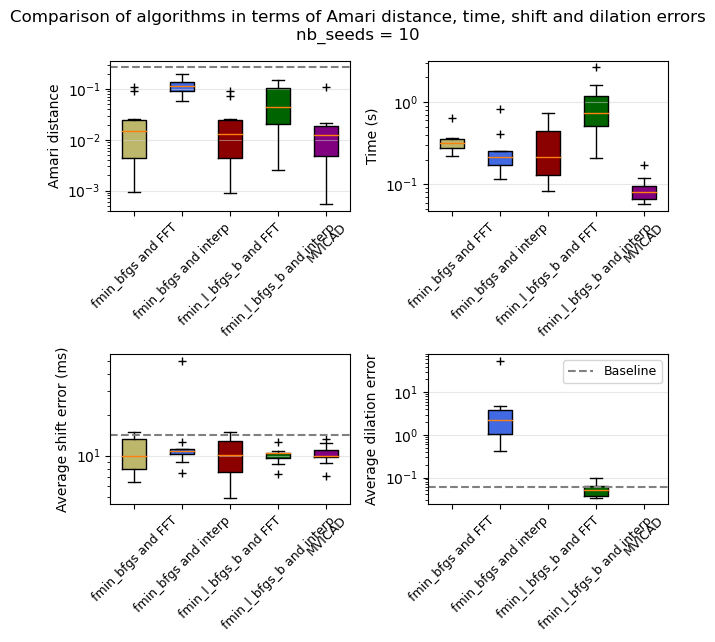

In [47]:
# plot
def one_subplot(data, ylabel, ax, logscale=False, average=None):
    bp = ax.boxplot(data)
    ax.set(ylabel=ylabel)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.setp(bp['fliers'], color='red', marker='+')
    box_colors = ['darkkhaki', 'royalblue', 'darkred', 'darkgreen', 'purple']
    nb_algos = len(data)
    for i in range(nb_algos):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(Polygon(box_coords, facecolor=box_colors[i]))
    ax.set_xticklabels(
        ['fmin_bfgs and FFT', 'fmin_bfgs and interp', 'fmin_l_bfgs_b and FFT', 'fmin_l_bfgs_b and interp', 'MVICAD'],
        rotation=45, fontsize=9)
    if logscale is True:
        ax.set_yscale('log')
    if average is not None:
        ax.axhline(average, c='grey', linestyle='--')

fig, axs = plt.subplots(2, 2, figsize=(6.5, 6.5))

one_subplot(
    [df_res_2['amari_fft'], df_res_2['amari_interp'], df_res_2['amari_fft_lbfgsb'],
     df_res_2['amari_interp_lbfgsb'], df_res_2['amari_mvicad']], 
    'Amari distance', 
    axs[0, 0], 
    logscale=True,
    average=mean_amari_random_2)
one_subplot(
    [df_res_2['time_fft'], df_res_2['time_interp'], df_res_2['time_fft_lbfgsb'],
     df_res_2['time_interp_lbfgsb'], df_res_2['time_mvicad']],
    'Time (s)',
    axs[0, 1],
    logscale=True)
one_subplot(
    [df_res_2['shifts_error_fft'], df_res_2['shifts_error_interp'], df_res_2['shifts_error_fft_lbfgsb'],
     df_res_2['shifts_error_interp_lbfgsb'], df_res_2['shifts_error_mvicad']],
    'Average shift error (ms)',
    axs[1, 0],
    logscale=True,
    average=mean_shifts_error_random_2)
null = np.full(nb_seeds, np.nan)
one_subplot(
    [null, df_res_2['dilations_error_interp'], null, df_res_2['dilations_error_interp_lbfgsb'], null],
    'Average dilation error',
    axs[1, 1],
    logscale=True,
    average=mean_dilations_error_random_2)

from matplotlib.lines import Line2D
plt.legend([Line2D([0], [0], linestyle='--', color='grey', lw=1.5)], ['Baseline'], fontsize=9)

plt.suptitle(f"Comparison of algorithms in terms of Amari distance, time, shift and dilation errors\nnb_seeds = {nb_seeds}")
plt.tight_layout()